In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import sys
sys.path.append('./Processus-Wishart-513/')

import sampling
import cir

# Test CIR Process

This document is used to test the implementation of CIR process simulation.

## The fllowing part is no more useful.

In [19]:
def general_normal(q, size=1):
    '''
    Function to generate the samples of generalised Gaussian distribution.
    * Param(s):
        q : The parameter q in N(0, 1, q). Positive integer.
        size : Size of the generated sample. Shall be an integer, or an 1d array/tuple of integers.
    '''
    # Check size.
    size = np.array(size, dtype=int)
    # Calculate the required number of sample instances.
    if size.size == 1: #i.e., the required size is an integer.
        num = size
    else:
        assert len(size.shape) == 1 
        num =1
        for x in size:
            num = num*x
    assert (num>0)
    # Calculate the number of U = [U1, ..., U_q] required.
    num_Z = int(np.ceil(num/q))
    
    # Generate.
    lst_Z = []
    while len(lst_Z) < num_Z:
        U = np.random.rand(q)
        U = 2*U - 1 # U ~ Uniform([-1, 1]).
        q_norm = np.linalg.norm(U, ord=q)
        if q_norm < 1: # This U satisfies the condistion.
            tmp = -2 * q * np.log(q_norm)
            numerator = np.power(tmp, 1/q) # The numerator.
            Z = U * (numerator/q_norm) # Z_i ~ N(0, 1, q), i.i.d..
            lst_Z.append(Z)
    # Build the required shape of samples. 
    lst_Zi = np.array(lst_Z).reshape(-1)
    assert len(lst_Zi) >= num
    X = (lst_Zi[:num]).reshape(size)
    return X
    

In [55]:
def chi_2(p, q, lam=0.0, size=1):
    '''
    Function used to generate the samples of Chi-square distribution, with specified params nu and lambda,
    and the given size.
    * Params:
        p, q : Indicating the degree of freedom by nu = p/q. Positive integers.
        lam: Default is 0. The center. Non-negative real number.
        size : Default is 1. Size of the generated sample. Shall be an integer, or an 1d array/tuple of integers.
    '''
    size = np.array(size, dtype=int)
    if size.size == 1: #i.e., the required size is an integer.
        num = size
    else:
        assert len(size.shape) == 1 
        num =1
        for x in size:
            num = num*x
    assert (num>0)
    
    # Examin p and q.
    assert isinstance(p, int) and isinstance(q, int)
    assert p>0 and q>0
    d = np.gcd(p, q)
    p = int(p/d)
    q = int(q/d)
    
    # Generate the generalized Gaussian variables.
    lst_Z = general_normal(q=2*q, size=(num, p))
    # Calculate the number of standard Gaussian required.
    assert lam>=0
    if lam == 0:
        lst_N = np.zeros(num, dtype=int)
    else:
        lst_N = np.random.poisson(lam=lam/2, size=num)
        lst_N = lst_N.astype(int)
    # Generate Chi-square variables.
    lst_X = []
    for i in range(num):
        Z = lst_Z[i]
        N = lst_N[i]
        Y = np.random.normal(size=N)
        X = np.sum(np.power(Z, 2*q)) + np.sum(Y*Y)
        lst_X.append(X)
    # reshape
    lst_X = np.array(lst_X).reshape(size)
    return lst_X

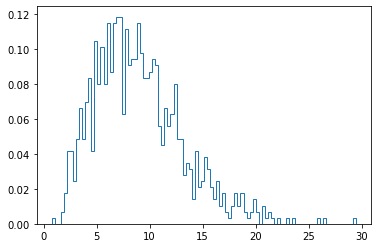

In [54]:
M = 1000
Z = general_normal(q=2, size=(M, 9))
X = np.sum(np.power(Z,2), axis=1)
plt.hist(X, bins=100, density=True, histtype='step')
plt.show()

In [3]:
import importlib
importlib.reload(random_CIR)

<module 'random_CIR' from './Processus-Wishart-513\\random_CIR\\__init__.py'>

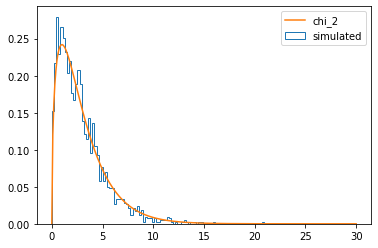

In [2]:
M = 2000
k = 3
X1 = random_CIR.chi_2(k,1, size=M)
x = np.linspace(0, 30, 300)

plt.hist(X1, bins=100, density=True, histtype='step', label='simulated')
plt.plot(x, stats.chi2.pdf(x, k), label='chi_2')
plt.legend()
plt.show()

In [2]:
random_CIR.chi_2(p=2, q=1, lam=np.arange(6).reshape(-1, 2))

array([[1.39895149, 0.33427591],
       [0.04378994, 1.21465761],
       [3.02214659, 4.46402293]])

In [6]:
lam = np.arange(6)
(lam >=0 ).all()

True

## New tests start from here.

In [2]:
import numpy as np
from fractions import Fraction
import sampling

class CIR:
    '''
    The Class of CIR process generator.
    '''
    max_q = 100
    def __init__(self, kappa, theta, epsilon, x0, exact=False, **kwargs):
        assert kappa > 0
        assert theta > 0
        assert epsilon > 0
        self.kappa = kappa
        self.theta = theta
        self.epsilon = epsilon
        self.x0 = x0
        
        self.nu = 4*kappa*theta / (epsilon*epsilon)
        if 'max_q' in kwargs:
            max_q = kwargs['max_q']
            assert isinstance(max_q, int) and max_q>0
        else:
            max_q = CIR.max_q
        frc = Fraction.from_float(self.nu)
        if not exact:
            frc = frc.limit_denominator(max_q)
        self.p = frc.numerator
        self.q = frc.denominator
    
    def nita(self, h):
        tmp = np.exp(-1*self.kappa * h)
        nomerator = 4 * self.kappa * tmp
        denominator = self.epsilon*self.epsilon * (1-tmp)
        return nomerator/denominator
    
    def __call__(self, T, n, num=1, x0=None):
        '''
        Function used to generate the discretized CIR process.
        * Params:
            T : Non-negative real number.
            n : Positive integer. The number of discretized time points.
            num : Positive integer. The number of independent CIR processes to generate.
            x0 : Real number. The initial value of V. If x0 is None, self.x0 is used.
        * Return:
            V : The generated process. Of shape (num, n+1).
        '''
        if x0 is None:
            x0 = self.x0
        num = int(num)
        assert T>=0 and n>0 and num>0
        h = T/n
        
        nita = self.nita(h)
        factor = np.exp(-1*self.kappa*h) / nita
        
        # Generate Vt.
        V = np.zeros((num, n+1))
        V[:, 0] = x0
        for i in range(1, n+1):
            Vt = V[:, i-1]
            lam_t = Vt * nita
            # Generate the chi-square distribution.
            Vt1 = sampling.chi_2(self.p, self.q, lam=lam_t)
            Vt1 = Vt1 * factor # Calculate V_t_{i+1}.
            V[:, i] = Vt1
        
        return V

9.950166250831895e-05


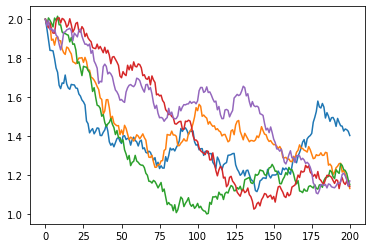

In [8]:
kappa = 1
theta = 1.2
epsilon=0.2
n = 200
T = 2.0


cir_gen = CIR(kappa, theta, epsilon, x0=2)
V = cir_gen(T=T, n=n, num=5)
h = T/n
nita = cir_gen.nita(h)
factor = np.exp(-1*cir_gen.kappa*h) / nita
print(factor)

plt.plot(V.T)
plt.show()

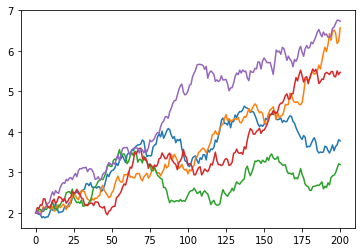

In [3]:
k = 0
a = 1.2
sigma = 0.5
n = 200
T = 2.0

cir_gen = cir.CIR(k, a, sigma, x0=2)
V = cir_gen(T=T, n=n, num=5)
plt.plot(V.T)
plt.show()

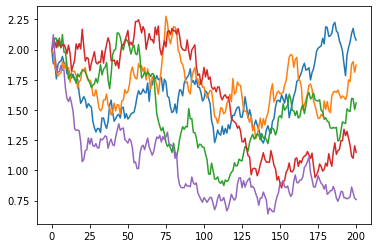

In [4]:
k = 1
a = 1.2
sigma = 0.5
n = 200
T = 2.0

cir_gen = cir.CIR(k, a, sigma, x0=2)
V = cir_gen(T=T, n=n, num=5)
plt.plot(V.T)
plt.show()

In [3]:
a = np.random.rand(6)
print(a)
np.argmax(a)

[0.60936612 0.66010375 0.73199971 0.45181963 0.2616034  0.8832664 ]


5

In [21]:
from wishart import wishart
import importlib
importlib.reload(wishart)

<module 'wishart.wishart' from './Processus-Wishart-513\\wishart\\wishart.py'>

In [22]:
x = np.array([[1,0],[1,2]])
b = np.array([[3,3],[3,3]])
a = np.array([[2,-1],[2,1]])
w = wishart.Wishart(x, 3, a, b)
t = 1

In [23]:
Xt = w.wishart_e(T=t, N=1000)

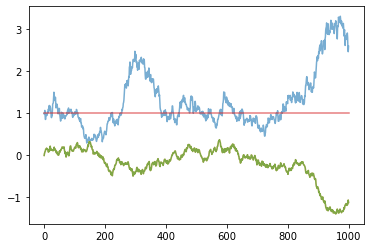

In [27]:
plt.plot(Xt.reshape(1001, -1), alpha=.6)
plt.show()